<a href="https://colab.research.google.com/github/ekrell/ams_ai_shortcourse_2025/blob/main/AMSAI2025_Exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMS AI Short Course

**Exercise: train and explore your own model**

In this exercise, you will train and explore a model. The purpose is to apply concepts from the Short Course modules, so we provide a **tabular dataset for a regression problem**.

Please form small groups and work together. You have a lot of freedom to develop your model! You will see that the tasks are open-ended like *characterize the distribution* and *investigate feature importance*. Each group should end up with very different results, and we can all compare at the end. So, use this chance to try out what you have learned, and take advantage of our short course instructors for guidance!

**Tasks**

1. Characterize the dataset: balanced? imbalanced?
2. Train a simple MLP model: with automatic hyperparameter tuning
3. Evaluate the model: global performance and performance across parts of the distribution.
4. Investigate the model: compute feature importance rankings

# Dataset

**Task:** predict visibility (e.g. fog) at the [KRAS](https://www.airnav.com/airport/KRAS) aiport in Port Aransas, Texas.

- Data file: [nam_fog_data_2009_2020.csv](https://github.com/ekrell/ams_ai_shortcourse_2024/blob/main/data/nam_fog_data_2009_2020.csv)
- Target column: `vis`
- Train years: 2010 - 2017
- Test year: 2020

**Note:** visibility is between [0, 10], where 0 means no visibility and 10 means ten meters **or more**.

The predictors were obtained from the [North American Mesoscale (NAM) Forecast System](https://www.ncei.noaa.gov/products/weather-climate-models/north-american-mesoscale).  

We are predicting visibility with a **24-hour lead time**. Our predictors are NAM's predictions for the weather conditions in 24 hours. So, the task is: given a numerical weather prediction (trained for all of North America), can we use observed visibility readings to **fine-tune** the model for a specific geographical location?

**Predictors:**

- `TMP_2maboveground`: Temperature, 2 meters above ground
- `TMP_975mb`: Temperature, 975 millibars
- `TMP_700mb`': Temperature, 700 millibars
- `UGRD_10maboveground`: U-Component of Wind, 10 meters above ground
- `VGRD_10maboveground`: V-Component of Wind, 0 meters above ground
- `UGRD_975mb`: U-Component of Wind, 975 millibars
- `VGRD_975mb`: V-Component of Wind, 975 millibars
- `TKE_975mb`: Turbulent kinetic energy, 975 millibars
- `UGRD_700mb`: U-Component of Wind, 700 millibars
- `VGRD_700mb`: V-Component of Wind, 700 millibars
- `TKE_700mb`: Turbulent kinetic energy, 700 millibars
- `Q_975mb`: Specific humidity, 975 millibars
- `Q_700mb`: Specific humidity, 700 millibars
- `RH_975mb`: Relatively humidity, 975 millibars
- `RH_700mb`: Relatively humidity, 700 millibars
- `DPT_2maboveground`: Dew point temperature,
- `Q_surface`: Specific humidity, surface
- `RH_2maboveground`: Relatively humidity, 2 meters above ground
- `LCLT`: Temperature at the LCL (lifted condensation level)
- `VIS_surface`: Visibility, surface
- `VVEL_975mb`: Vertical velocity, 975 millibars
- `VVEL_700mb`: Vertical velocity, 700 millibars

# Basic setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Download
!wget https://github.com/ekrell/ams_ai_shortcourse_2024/raw/refs/heads/main/data/nam_fog_data_2009_2020.csv
!ls

--2025-01-11 05:23:45--  https://github.com/ekrell/ams_ai_shortcourse_2024/raw/refs/heads/main/data/nam_fog_data_2009_2020.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/refs/heads/main/data/nam_fog_data_2009_2020.csv [following]
--2025-01-11 05:23:46--  https://raw.githubusercontent.com/ekrell/ams_ai_shortcourse_2024/refs/heads/main/data/nam_fog_data_2009_2020.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18923812 (18M) [text/plain]
Saving to: ‘nam_fog_data_2009_2020.csv’

nam_fog_data_2009_2 100%[===================>]  18.05M  80.7MB/s    in 0.2s    



In [ ]:
df = pd.read_csv('nam_fog_data_2009_2020.csv')

# Drop useless column
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Drop "class" since we are doing regression
df.drop(columns=['vis_class'], inplace=True)

# Set datetime index
df['Datetime'] = pd.to_datetime(df['date_time'])
df = df.set_index('Datetime')

# For simplcity, drop all rows with NaNs
df.dropna(inplace=True)

# Drop all predictors except the NAM 24-hour output
df = df.loc[:, ~df.columns.str.contains('_000')]
# Drop predictors (t- hours)
df = df.loc[:, ~df.columns.str.contains('_006')]
# Drop predictors (t-24 hours)
df = df.loc[:, ~df.columns.str.contains('_012')]

df.columns = df.columns.str.rstrip('_024')

# Select years
df_train = df.loc[(df.index.year >= 2010) & (df.index.year < 2018)]

df_test = df.loc[df.index.year == 2020]

In [ ]:
df_train

,date_time,vis,TMP_2maboveground,TMP_975mb,TMP_700mb,UGRD_10maboveground,VGRD_10maboveground,UGRD_975mb,VGRD_975mb,TKE_975mb,...,Q_700mb,RH_975mb,RH_700mb,DPT_2maboveground,Q_surface,RH_2maboveground,LCLT,VIS_surface,VVEL_975mb,VVEL_700mb
Datetime,,,,,,,,,,,,,,,,,,,,,
2010-01-01 00:00:00,20100101 00:00:00,7.0,-2.860501,-3.262541,-1.450861,0.877359,-1.748613,0.696930,-1.545018,0.601340,...,-1.741248,-1.160202,-1.717636,-2.923262,-2.369547,-1.600501,-2.955293,0.492616,3.775061,1.139637
2010-01-01 06:00:00,20100101 06:00:00,10.0,-2.063483,-2.164645,-0.493543,1.266969,-0.374492,-0.236471,-0.520020,-0.929023,...,-1.726022,-4.331531,-1.717636,-2.370311,-2.119407,-1.889653,-2.468508,0.575058,4.996907,0.311395
2010-01-01 12:00:00,20100101 12:00:00,10.0,-2.063064,-1.921369,-0.535066,0.569860,-1.331933,0.155328,-0.401657,-0.877230,...,-1.601975,-4.807230,-1.577048,-2.596223,-2.222336,-2.371574,-2.717452,0.575499,0.445830,0.576840
2010-01-01 18:00:00,20100101 18:00:00,10.0,-1.970682,-2.258639,-1.046351,-1.525294,-0.730116,-1.224326,-0.637829,-0.284352,...,-1.024296,-1.001636,-0.827246,-2.137504,-1.992742,-1.504117,-2.207938,0.493302,-2.262120,-0.363698
2010-01-02 00:00:00,20100102 00:00:00,10.0,-1.963191,-2.240752,-1.183552,-1.469332,-0.359675,-1.117192,-0.444598,-0.253102,...,-0.682654,-0.446653,-0.358620,-2.061472,-1.945625,-1.311349,-2.111618,0.493099,-0.847707,-0.363367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-23 23:55:00,20170823 23:55:00,10.0,0.563232,0.632293,0.503785,-0.571990,-0.825625,-0.154813,-0.730807,-1.199309,...,1.960814,-0.208804,1.609610,0.817669,0.919507,0.866822,0.876536,0.519667,12.831716,15.209593
2017-08-24 05:55:00,20170824 05:55:00,10.0,1.069636,1.030082,0.375191,-1.637435,-0.412620,-1.298546,-0.517547,-0.783774,...,2.318770,-0.041476,2.031373,0.791757,0.891136,-0.400403,0.740608,0.519667,2.113080,-0.234244
2017-08-24 11:55:00,20170824 11:55:00,10.0,1.154253,1.104054,0.292023,-2.076894,-0.591079,-1.773926,-0.643813,1.155386,...,2.307772,-0.511667,2.086373,0.742987,0.815807,-0.700079,0.665391,-1.731518,-0.756252,-1.687899


<Axes: xlabel='Datetime'>

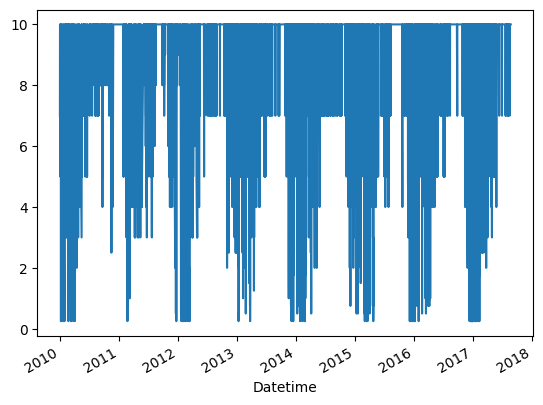

In [ ]:
df_train["vis"].plot()

<Axes: xlabel='Datetime'>

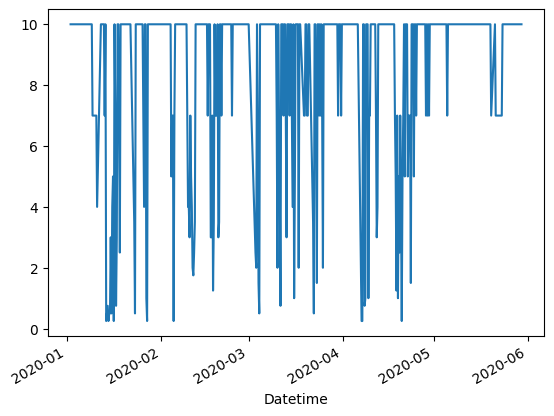

In [ ]:
df_test["vis"].plot()

# 1. Characterize the dataset

# 2. Train a simple MLP regression model

# 3. Evaluation the model

# 4. Investigate the model